In [2]:
from abc import ABC, abstractmethod
from random import randint
from typing import List
from copy import deepcopy
from math import sqrt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class Insertion:
    def __init__(self, index, value):
        self.index = index
        self.value = value

    def __repr__(self):
        return f"Insertion at {self.index} with value {self.value}"
    

class Position:
    def __init__(self, x : float, y : float):
        self.x = x
        self.y = y

    def distanceVers(self, p):
        return sqrt((p.x - self.x)**2 + (p.y - self.y)**2)

    def __repr__(self):
        return f"({self.x}, {self.y})"

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def dcop_repr(self):
        return f"{self.x}{self.y}"

class Task:
    def __init__(self, o : Position, d : Position):  
        self.origin : Position = Position(o.x, o.y)
        self.destination : Position = Position(d.x, d.y)

    def __repr__(self):
        return f"{self.origin} to ({self.destination})"
    
    def dcop_repr(self):
        return f"task_{self.origin.dcop_repr()}_to_{self.destination.dcop_repr()}"
    

class Taxi:
    def __init__(self, position = Position(0, 0)):
        self.position : Position = deepcopy(position)
        self.tasks : List[Task] = []
        self.currentTask = None
        self.id = id(self)
        self.timer = 0

    def computeTasksLength(self):
        acc = 0
        taxi_temp_pos = Position(self.position.x, self.position.y)

        for t in self.tasks:
            acc += taxi_temp_pos.distanceVers(t.origin)
            acc += t.origin.distanceVers(t.destination)
            taxi_temp_pos = t.destination

        return acc
    
    def computeLengthOfTask(self, t : Task):
        return self.position.distanceVers(t.origin) + t.origin.distanceVers(t.destination)

    
    def endCurrentTask(self):
        """pas de reset timer systématique pour prise en compte du temps perdu sur le timestamp precedent"""

        self.position = self.currentTask.destination
        self.currentTask = None
        
        if len(self.tasks) == 0:
            self.timer = 0

    def startNewTask(self):
        """ajout au timer pour prise en compte du temps perdu sur le timestamp precedent, sinon assigner"""
        if len(self.tasks) > 0:
            new_task = self.tasks.pop(0)
            self.timer += self.computeLengthOfTask(new_task)
            self.currentTask = new_task

    def __str__(self):
        return f"Taxi {self.id} at {self.position} ; current {self.currentTask} timer {self.timer} \n and tasks len {self.computeTasksLength()} : {self.tasks}"


def computeTasksLengthFrom(starting_position, tasks):
    acc = 0
    taxi_temp_pos = starting_position

    for t in tasks:
        acc += taxi_temp_pos.distanceVers(t.origin)
        acc += t.origin.distanceVers(t.destination)
        taxi_temp_pos = t.destination
    return acc


class Environnement:
    def __init__(self, size, taxis):
        self.size : int = size
        self.tasks_to_ord : List[Task] = []
        self.taxis : List[Taxi] = taxis
        
class TaskGenerator(ABC):
    
    def __init__(self, tasks_ct, env, freq):
        super().__init__()
        self.tasks_ct : int = tasks_ct
        self.env : Environnement = env
        self.freq : int = freq
    
    def shouldGenerate(self, timestamp):
        return timestamp % self.freq == 0
    
    @abstractmethod
    def generate_tasks(self):
        pass



class TestGenerator1(TaskGenerator):
    def __init__(self, tasks_ct, env, freq):
        super().__init__(tasks_ct, env, freq)

    def generate_tasks(self):
        tasks = []
        tasks.append(Task(Position(2.2, 2.2), Position(3.3, 3.3)))
        
        tasks.append(Task(Position(9.2, 9.2), Position(9.9, 9.9)))
        tasks.append(Task(Position(1.1, 1.1), Position(9.1, 8.1)))

        self.env.tasks_to_ord = tasks
    
    def __str__(self):
        return f"Test Generator 1 of size {self.env.size} generating {self.tasks_ct} tasks"


class RandomGenerator(TaskGenerator):

    def __init__(self, tasks_ct, env, freq):
        super().__init__(tasks_ct, env, freq)

    def generate_tasks(self):
        tasks = []
        for _ in range(self.tasks_ct):
           o = Position(randint(0, self.env.size), randint(0, self.env.size))
           d = Position(randint(0, self.env.size), randint(0, self.env.size))
    
           t = Task(o, d)
           tasks.append(t)
        
        return tasks
    
    def __str__(self):
        return f"Random Generator of size {self.env.size} generating {self.tasks_ct} tasks"


def createGenerator(gen, tasks_ct, env, freq):
    if gen == "rd":
        return RandomGenerator(tasks_ct, env, freq)
    
    if gen == "test1":
        return TestGenerator1(tasks_ct, env, freq)

    raise NotImplementedError("Unknown Generator Type")



class Ordonnancement(ABC):
    
    def __init__(self, env):
        self.env : Environnement = env
    
    @abstractmethod
    def algo_assign(self):
        pass

    def ordonnancer(self):
        self.algo_assign()
        self.env.tasks_to_ord = []

    def __str__(self):
        return "Ordonnancement "


"""
Tout assigner au premier taxi
"""
class OrdonnancementUn(Ordonnancement):
    def algo_assign(self):
        t = self.env.taxis[0]
        t.tasks = self.env.tasks_to_ord
    
    def __str__(self):
        return super().__str__() + " Un"






def parse_args_default():
    return 3, 10, 20, "rd", 5, 100, True

def parse_args():
    

    taxis_ct = int(input("Taxi count : "))
    
    env_size = int(input("Env size : "))
    
    task_freq = int(input("Task freq : "))

    task_method = str(input("Task Method : "))

    tasks_ct = int(input("Task count : "))

    total_time = int(input("Total time : "))

    taxi_random_location = input("Random taxi location ? (y/n) : ") == "y"
    return taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxi_random_location

def initialize(taxis_ct, env_size, task_freq, task_method, tasks_ct, random_taxi_location = False):
    taxis = []
    
    if random_taxi_location:
        for _ in range(taxis_ct):
            taxis.append(Taxi(Position(randint(0, env_size), randint(0, env_size))))

    else:
        for _ in range(taxis_ct):
            taxis.append(Taxi())

    env = Environnement(env_size, taxis)

    generator = createGenerator(task_method, tasks_ct, env, task_freq)

    return env, generator



def format_legend_labels(x, pos):
    return f"{x:.2f}"


def multi_main(reps, ord, taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxis_random_location = False):
    cumuls = []
    seps = {}


    
    for _ in range(reps):
        sep, cumul = main(ord, taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxis_random_location, plots = False)
        cumuls.append(cumul)
        
        for taxi, values in sep.items():
            if taxi not in seps:
                seps[taxi] = [] 
            seps[taxi].append(values)
    

    fin = {}
    ad = []
    for taxi, vals in seps.items():
        mns = np.mean(vals, axis = 0)
        fin[taxi] = mns
        ad.append(mns)
 


    maxs = np.maximum.reduce(ad)
    plt.title("Moyenne des valeurs pour chaque taxi, maximum des moyennes")
    plt.plot(maxs)
    plt.show()

    means = np.mean(cumuls, axis=0)

        
    plt.plot(means)
    plt.title(f"{ord} average over {reps} runs")
    plt.legend()
    plt.show()

    
    pd.Series(means).round(decimals = 0).value_counts(sort=True).plot(kind='bar')

    plt.title("Frequence d'apparition des durees restantes")

    plt.show()

    
def main(ord, taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxis_random_location = False, plots = True):
    
    env, gen = initialize(taxis_ct, env_size, task_freq, task_method, tasks_ct, taxis_random_location)
    
    ord = ord(env)

    taxis_cumul_ord = []
    by_taxi_ord = {}

    for taxi in env.taxis:
        by_taxi_ord[taxi] = []

    for timestamp in range(total_time):
        
        #print(f"Timestamp : {timestamp}")
        
        if gen.shouldGenerate(timestamp):
            tasks = gen.generate_tasks()
            env.tasks_to_ord = tasks

            ord.ordonnancer()

        acc = 0

        for taxi in env.taxis:
            #print(f"Taxi {taxi.id} with current {taxi.currentTask}, timer {taxi.timer} and scheduled {taxi.tasks}")

            if taxi.currentTask == None:
                taxi.startNewTask()
            else:
                taxi.timer -= 1
                if taxi.timer <= 0:
                    taxi.endCurrentTask()
                    taxi.startNewTask()
            

            tasks_len = taxi.computeTasksLength() 
            acc += tasks_len
            by_taxi_ord[taxi].append(tasks_len)

            #print(taxi)
        
        taxis_cumul_ord.append(acc)
        #print("\n\n")
    
    if plots:
        plt.plot(taxis_cumul_ord, label=f"Cumulé {ord}")
        plt.legend()
        pd.DataFrame(by_taxi_ord).plot()

        plt.show() 

    return by_taxi_ord, taxis_cumul_ord
            #for idx, taxi in enumerate(env.taxis):
            #    print(f"Taches taxi {idx} :" + str(taxi.tasks))


def compare_main(ord1, ord2, taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxi_random_location):

    env, gen = initialize(taxis_ct, env_size, task_freq, task_method, tasks_ct, taxi_random_location)
    env2, _ = initialize(taxis_ct, env_size, task_freq, task_method, tasks_ct, taxi_random_location)

    ord1 = ord1(env)
    ord2 = ord2(env2)

    ## METRICS

    taxis_cumul_dord1 = []
    taxis_cumul_dord2 = []
    by_taxi_ord1 = {}
    by_taxi_ord_2 = {}

    for taxi in env.taxis:
        by_taxi_ord1[taxi] = []
    
    for taxi in env2.taxis:
        by_taxi_ord_2[taxi] = []

    ## ALGO

    for timestamp in range(total_time):
        print(f"Timestamp {timestamp}")
        if gen.shouldGenerate(timestamp):
            tasks = gen.generate_tasks()
            env.tasks_to_ord = deepcopy(tasks)
            env2.tasks_to_ord = deepcopy(tasks)

            ord1.ordonnancer()
            ord2.ordonnancer()

        print(f"\n{ord1}\n")
        acc = 0

        for taxi in env.taxis:
            #print(f"Taxi {taxi.id} with current {taxi.currentTask}, timer {taxi.timer} and scheduled {taxi.tasks}")
            if taxi.currentTask == None:
                taxi.startNewTask()
            else:
                taxi.timer -= 1
                if taxi.timer <= 0:
                    taxi.endCurrentTask()
                    taxi.startNewTask()
                
            tasks_len = taxi.computeTasksLength() 
            acc += tasks_len
            by_taxi_ord1[taxi].append(tasks_len)

            print(taxi)
        
        taxis_cumul_dord1.append(acc)
        
        acc = 0
        
        print(f"\n{ord2}\n")

        for taxi in env2.taxis:
            #print(f"Taxi {taxi.id} with current {taxi.currentTask}, timer {taxi.timer} and scheduled {taxi.tasks}")
            if taxi.currentTask == None:
                taxi.startNewTask()
            else:
                taxi.timer -= 1
                if taxi.timer <= 0:
                    taxi.endCurrentTask()
                    taxi.startNewTask()
            
            tasks_len = taxi.computeTasksLength() 
            acc += tasks_len
            by_taxi_ord_2[taxi].append(tasks_len)

            print(taxi)
        taxis_cumul_dord2.append(acc)
        
        acc = 0
    
    #print("METRICS")

    #print(taxis_cumul_dord1)
    #print(taxis_cumul_dord2)

    #print("BY TAXI")
    #print(by_taxi_ord1)
    #print(by_taxi_ord_2)


    plt.plot(taxis_cumul_dord1, label=f"Cumulé {ord1}")
    plt.plot(taxis_cumul_dord2, label=f"Cumulé {ord2}")

    plt.legend()
    
    pd.DataFrame(by_taxi_ord1).plot() 
    pd.DataFrame(by_taxi_ord_2).plot() 

    plt.show()



In [4]:
from copy import deepcopy

class OrdonnancementPartieUne(Ordonnancement):
    """
    Chemin a distance optimale, un seul taxi
    """

    def algo_assign(self):

        print("Ordonnancement Partie Une")
        print(f"Taxis : {self.env.taxis}")
        
        nb_taxis = len(self.env.taxis)

        tasks = self.env.tasks_to_ord
        
        
        for task in tasks:
            for taxi in self.env.taxis:
                #inser = range(len(taxi.tasks)):
                inser = len(taxi.tasks)
                    
                if inser == 0:
                    taxi.tasks = [task]
                    continue                
    
                elif inser == 1:
                    tent1 = deepcopy(taxi.tasks)
                    tent2 = deepcopy(taxi.tasks)

                    tent1.insert(0, task)
                    tent2.insert(1, task)
                    
                    taxi.tasks = tent1 if computeTasksLengthFrom(taxi.position, tent1) < computeTasksLengthFrom(taxi.position, tent2) else tent2
                    continue

                else :
                    tent_base = deepcopy(taxi.tasks)
                    tent_base.insert(0, task)

                    for i in range(len(taxi.tasks)):
                        tentN = deepcopy(taxi.tasks)
                        tentN.insert(i, task)

                        if computeTasksLengthFrom(taxi.position, tentN) < computeTasksLengthFrom(taxi.position, tent_base):
                            tent_base = tentN
                    
                    
                    taxi.tasks = tent_base
                    

    def __str__(self):
        return super().__str__() + "Partie Une "


def testPartie1():
   
    taxis_ct = 1
    env_size = 10
    task_freq = 15
    task_method = "test1"
    task_ct = 5
    total_time = 20
    
    env, gen = initialize(taxis_ct, env_size, task_freq, task_method, task_ct)
    ord = OrdonnancementPartieUne(env)

    tasks = []

    gen.generate_tasks()
    ord.ordonnancer()

    for idx, taxi in enumerate(env.taxis):
        print(f"Taxi : {idx} : " + str(taxi.tasks))
        print(f"Distance : " + str(taxi.computeTasksLength()))


In [5]:
from copy import deepcopy

class OrdonnancementDCOPSimple(Ordonnancement):
    """
    Ordonnancement DCOP, par distance au point initial
    """
    
    def algo_assign(self):
        tasks = deepcopy(self.env.tasks_to_ord)
        costs = {}

        
        
        for task in tasks:
            costs[task] = {}
            for taxi in self.env.taxis:
                costs[task][taxi] = computeTasksLengthFrom(taxi.position, [task])
        

        print(f"costs : " + str(costs))

        self.write_pydcop_file(costs)

        print("pydcop file written") 


    def write_pydcop_file(self, costs):

        with open("pydcop_file.yaml", "w") as f:
            f.write("name: taxi assignment\n")
            f.write("objective: min\n")
            
            f.write("\n\n")

            f.write("domains:\n")
            f.write("  assignement:\n")
            f.write(f"    values: {[taxi.id for taxi in self.env.taxis]}\n")
            f.write("    type: non_semantic\n")

            f.write("\n\n")
            
            f.write("variables:\n")
            
            for task, _ in costs.items():
                f.write(f"  {task.dcop_repr()}:\n")
                f.write("    domain: assignement\n")
                f.write("\n")

            f.write("\n\n")

            f.write("constraints:\n")

            for task, values in costs.items():
                
                f.write(f"  {task.dcop_repr()}_length:\n")
                f.write(f"    type: intention\n")
                f.write(f"    function: |\n")
                for taxi, cost in values.items():
                    f.write(f"      if {task.dcop_repr()} == {taxi.id}:\n")
                    f.write(f"        return {cost}\n")
                    f.write("\n")

            f.write("\n\n")
            f.write(f"agents: { [f"ag_{i}"for i in range(len(costs))]} \n")

            
            #for i in range(len(costs)):
            #    f.write(f"  ag_{i}:\n")




In [6]:
from copy import deepcopy

"""
Ordonnancement SSI, heuristique de l'insertion
"""

class OrdonnancementSSIInsertion(Ordonnancement):
    """
    Ordonnancement SSI
    """

     
    def algo_assign(self):
        #print("Ordonnancement SSI")
        #print(f"Taxis : {self.env.taxis}")
        
        tasks = self.env.tasks_to_ord
        
        for task in tasks: 

            min_offer_taxi = None
            min_offer_value = float('inf')
            min_offer_index = -1

            
            for taxi in self.env.taxis:
                temp_tasks = deepcopy(taxi.tasks)

                inser = len(temp_tasks)

                value = float('inf')
                index = -1
                
                if inser == 0:
                    value = taxi.position.distanceVers(task.origin) + task.origin.distanceVers(task.destination)
                    index = 0
                    
                    if (value < min_offer_value):
                        min_offer_value = value
                        min_offer_taxi = taxi
                        min_offer_index = index
                    
                elif inser == 1:
                    tent1 = deepcopy(taxi.tasks)
                    tent2 = deepcopy(taxi.tasks)

                    tent1.insert(0, task)
                    tent2.insert(1, task)
                    
                    len1 = computeTasksLengthFrom(taxi.position, tent1)
                    len2 = computeTasksLengthFrom(taxi.position, tent2)

                    index, value = (0,len1) if len1 < len2 else (1,len2)
                    
                    if (value < min_offer_value):
                        min_offer_value = value
                        min_offer_taxi = taxi
                        min_offer_index = index

                else :

                    tenta = deepcopy(taxi.tasks)
                    tenta.insert(0, task)

                    index = 0
                    value = computeTasksLengthFrom(taxi.position, tenta)

                    for i in range(len(taxi.tasks)):
                        nth_tent = deepcopy(taxi.tasks)
                        nth_tent.insert(i, task)

                        nth_value = computeTasksLengthFrom(taxi.position, nth_tent)
                        
                        if nth_value < value:
                            tenta = nth_tent
                            index = i
                            value = nth_value
                       

                    if (value < min_offer_value):
                        min_offer_value = value
                        min_offer_taxi = taxi
                        min_offer_index = index

      

            min_offer_taxi.tasks.insert(min_offer_index, task)

    def __str__(self): 
        return super().__str__() + "SSI Insertion "



class OrdonnancementSSIInsertionRegret(OrdonnancementSSIInsertion):
    """
    Ordonnancement SSI Regret
    """

    
    def algo_assign(self):
        #print("Ordonnancement SSI Regret")

        tasks = deepcopy(self.env.tasks_to_ord)
        for loop in range(len(self.env.tasks_to_ord)):

            #print(f"Loop : {loop}")
            #print(f"Tasks : {tasks}")

            #print(f"Taxis : {self.env.taxis}\n")



            regrets = {}
            offers = {}

            for index, task in enumerate(tasks): 


                #min_offer_taxi = None
                #min_offer_value = float('inf')
                #min_offer_index = -1
                
                
                offers[index] = {}
                
                for taxi in self.env.taxis:
                    temp_tasks = deepcopy(taxi.tasks)

                    inser = len(temp_tasks)

                    
                    if inser == 0:
                        value = taxi.position.distanceVers(task.origin) + task.origin.distanceVers(task.destination)
                        
                        offers[index][taxi] = Insertion(0, value)


                    elif inser == 1:
                        tent1 = deepcopy(taxi.tasks)
                        tent2 = deepcopy(taxi.tasks)

                        tent1.insert(0, task)
                        tent2.insert(1, task)
                        
                        len1 = computeTasksLengthFrom(taxi.position, tent1)
                        len2 = computeTasksLengthFrom(taxi.position, tent2)

                        index_inser, value = (0,len1) if len1 < len2 else (1,len2)
                        offers[index][taxi] = Insertion(index_inser, value)
                        

                    else :

                        tenta = deepcopy(taxi.tasks)
                        tenta.insert(0, task)

                        index_inser = 0
                        value = computeTasksLengthFrom(taxi.position, tenta)

                        for i in range(len(taxi.tasks)):
                            nth_tent = deepcopy(taxi.tasks)
                            nth_tent.insert(i, task)

                            nth_value = computeTasksLengthFrom(taxi.position, nth_tent)
                            
                            if nth_value < value:
                                tenta = nth_tent
                                index_inser = i
                                value = nth_value
                        

                        offers[index][taxi] = Insertion(index_inser, value)

        

            
            min_offers_taxi = {}
            for task_index, taxis_offers in offers.items():
                values = set(list(taxis_offers.values()))


                min_offer : Insertion = sorted(values, key= lambda insertion : insertion.value)[0]
                second_offer : Insertion = sorted(values, key= lambda insertion : insertion.value)[1]

                regrets[task_index] = abs(min_offer.value - second_offer.value)
                min_offers_taxi[task_index] = list(taxis_offers.keys())[list(taxis_offers.values()).index(min_offer)]




            #print(f"Offers : {offers}")
            #print(f"Regrets : {regrets}")

            #print(f"Min offers : {min_offers_taxi}\n")

            max_regret_task_index = max(regrets, key=regrets.get)
            max_regret_task = tasks[max_regret_task_index]
            

            best_taxi = min_offers_taxi[max_regret_task_index]

            best_taxi.tasks.insert(offers[max_regret_task_index][best_taxi].index, max_regret_task)
            tasks.remove(max_regret_task)


    def __str__(self):
        return super().__str__() + "Regret"
    



class OrdonnancementPSI(Ordonnancement):
    """
    Ordonnancement PSI
    """

    def algo_assign(self):
        tasks = deepcopy(self.env.tasks_to_ord)

        for task in tasks:

            min_offer_taxi = self.env.taxis[0]
            min_offer_value = self.env.taxis[0].position.distanceVers(task.origin) + task.origin.distanceVers(task.destination)
            
            for taxi in self.env.taxis:
                value = taxi.position.distanceVers(task.origin) + task.origin.distanceVers(task.destination)
                if value < min_offer_value:
                    min_offer_value = value
                    min_offer_taxi = taxi
        
            min_offer_taxi.tasks.append(task)
            


    def __str__(self):
        return super().__str__() + "PSI"

0 : Paramétrage
2 : Ordonnancement Partie 1
3 : Ordonnancement SSI Insertion
4 : Ordonnancement SSI Insertion Regret
5 : Comparaison SSI Insertion vs SSI Insertion Regret
6 : Ordonnancement PSI
7 : Comparaison SSI Insertion vs PSI
8 : Ordonnancement DCOP Simple
10 : Multi
9 : Quit


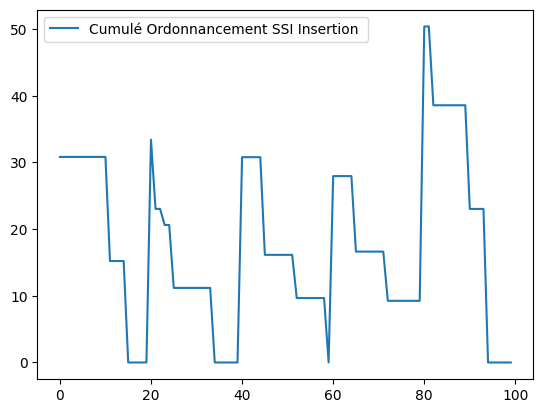

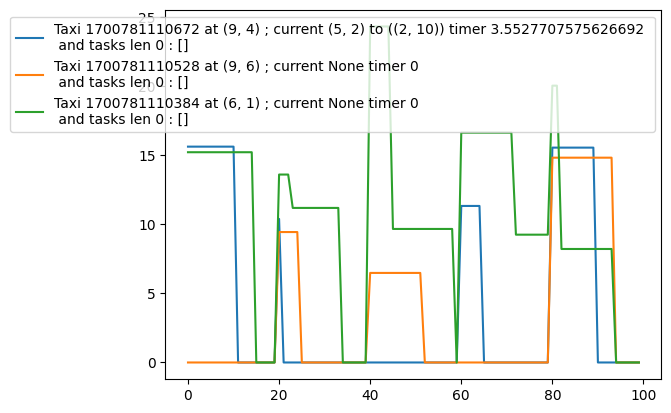

0 : Paramétrage
2 : Ordonnancement Partie 1
3 : Ordonnancement SSI Insertion
4 : Ordonnancement SSI Insertion Regret
5 : Comparaison SSI Insertion vs SSI Insertion Regret
6 : Ordonnancement PSI
7 : Comparaison SSI Insertion vs PSI
8 : Ordonnancement DCOP Simple
10 : Multi
9 : Quit
1 : Ordonnancement SSI Insertion
2 : Ordonnancement SSI Insertion Regret
3 : Ordonnancement PSI


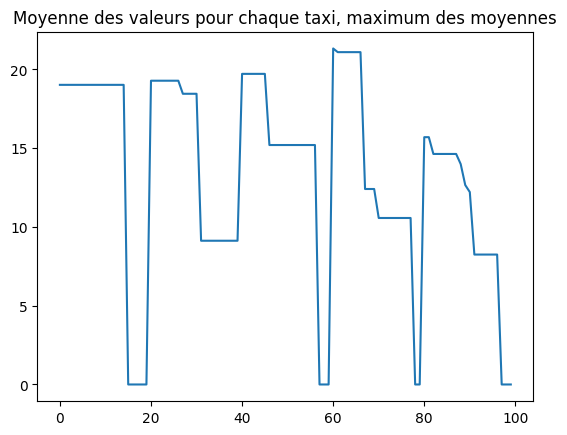

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


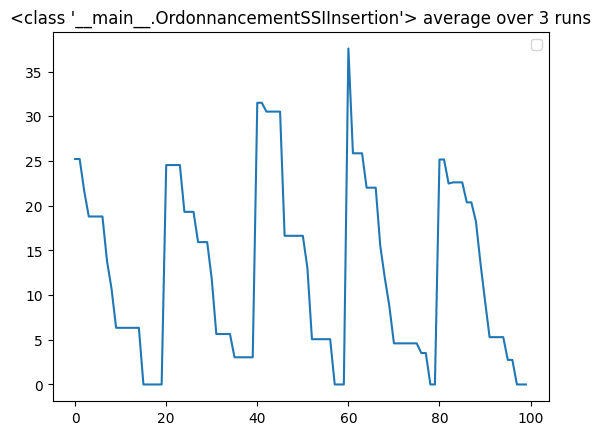

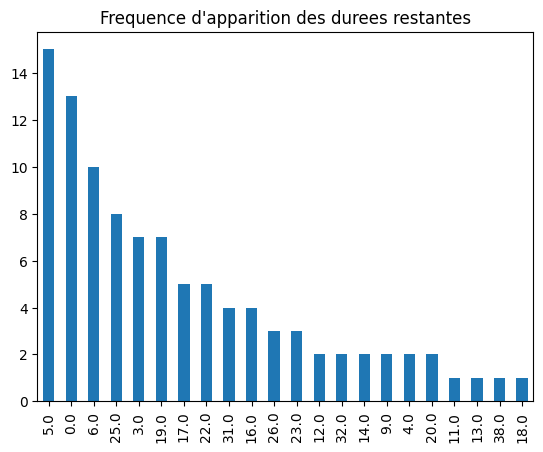

0 : Paramétrage
2 : Ordonnancement Partie 1
3 : Ordonnancement SSI Insertion
4 : Ordonnancement SSI Insertion Regret
5 : Comparaison SSI Insertion vs SSI Insertion Regret
6 : Ordonnancement PSI
7 : Comparaison SSI Insertion vs PSI
8 : Ordonnancement DCOP Simple
10 : Multi
9 : Quit


In [7]:

def desk():
    
    taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxi_random_location = parse_args_default()


    while True:
    
        print("0 : Paramétrage")
        
        print("2 : Ordonnancement Partie 1")
        
        print("3 : Ordonnancement SSI Insertion")
        print("4 : Ordonnancement SSI Insertion Regret")
        print("5 : Comparaison SSI Insertion vs SSI Insertion Regret")
        print("6 : Ordonnancement PSI")
        print("7 : Comparaison SSI Insertion vs PSI")

        print("8 : Ordonnancement DCOP Simple")

        print("10 : Multi")

        print("9 : Quit")


        value = int(input("Valeur : "))

    

        if value == 0:
            taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxi_random_location = parse_args()
            print(f"values : {taxis_ct} {env_size} {task_freq} {task_method} {taxis_ct} {total_time} {taxi_random_location}")
        
        if value == 1:
            testPartie1()
        
        elif value == 2:
            main(OrdonnancementPartieUne, taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxi_random_location)

        elif value == 3:

            main(OrdonnancementSSIInsertion, taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxi_random_location)

        elif value == 4:
            main(OrdonnancementSSIInsertionRegret, taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxi_random_location)
        

        elif value == 5:
            compare_main(OrdonnancementSSIInsertion, OrdonnancementSSIInsertionRegret, taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxi_random_location)

        elif value == 6:
            main(OrdonnancementPSI, taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxi_random_location)
        
        elif value == 7:
            compare_main(OrdonnancementSSIInsertion, OrdonnancementPSI, taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxi_random_location)
        
        elif value == 8:
            main(OrdonnancementDCOPSimple, taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxi_random_location)

        elif value == 9:
            break

        elif value == 10:
            reps = int(input("Reps : "))

            print("1 : Ordonnancement SSI Insertion")
            print("2 : Ordonnancement SSI Insertion Regret")
            print("3 : Ordonnancement PSI")

            algodx = int(input("Algo : "))
    
            algo = None

            if algodx == 1:
                algo = OrdonnancementSSIInsertion
            elif algodx == 2:
                algo = OrdonnancementSSIInsertionRegret
            elif algodx == 3:
                algo = OrdonnancementPSI
            else:
                print("Error")

            multi_main(reps, algo, taxis_ct, env_size, task_freq, task_method, tasks_ct, total_time, taxi_random_location)

        else:
            print("Valeur incorrecte")


desk()